# The use and misuse of over-representation pathway enrichment analysis in metabolomics

#### This notebook contains the code to run the following simulations:
- <a href='#s1'>Background list</a>
- <a href='#s2'>DA metabolite list size</a>
- <a href='#s3'>General vs. organism-specific pathway set</a>
- <a href='#s4'>Database size</a>
- <a href='#s5'>Metabolite misidentification</a>
- <a href='#s6'>Metabolite polarity</a>

#### The following scripts are required to be able to run the code. They should be saved in the same folder as this notebook. 
- process_datasets.py: Pre-processing of abundance matrices for the required datasets. 
- utils.py: Utilities for t-tests, ORA, and simulations.

All packages required are listed in the requirements.txt file. All simulations have been tested using Python version 3.8. Please note, some cells will take several minutes to run depending on the number of permutations the simulation is repeated for. 

In [ ]:
pip install -r requirements.txt # install the required packages

In [1]:
import utils
import process_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Import the relevant datasets
print("Processing datasets...")
DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

# Import pathway sets
KEGG_reference_pathways = pd.read_csv("KEGG_reference_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
all_KEGG_human_bg = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_eco_bg = list(set([x for x in KEGG_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_mouse_bg = list(set([x for x in KEGG_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

# param grid
datasets = {"Auwerx": [DEM_auwerx, background_auwerx, KEGG_human_pathways, all_KEGG_human_bg, mat_auwerx, [i for i in range(0, 14, 1)], [i for i in range(0, 12, 1)]],
            "Yamada": [DEM_yamada, background_yamada, KEGG_human_pathways, all_KEGG_human_bg, mat_yamada, [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)]],
            "Stevens": [DEM_stevens, background_stevens, KEGG_human_pathways, all_KEGG_human_bg, mat_stevens],
            "Brown": [DEM_brown, background_brown, KEGG_mouse_pathways, all_KEGG_mouse_bg, mat_brown, [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)]],
            "Zamboni (yfgM)": [DEM_yfgM, background_yfgM, KEGG_eco_pathways, all_KEGG_eco_bg, mat_yfgM, [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)]],
            "Zamboni (dcuS)": [DEM_dcuS, background_dcuS, KEGG_eco_pathways, all_KEGG_eco_bg, mat_dcuS, [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)]]}

print("Data import complete.")

Processing datasets...


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Data import complete.


<a id='s1'></a>
## Background list

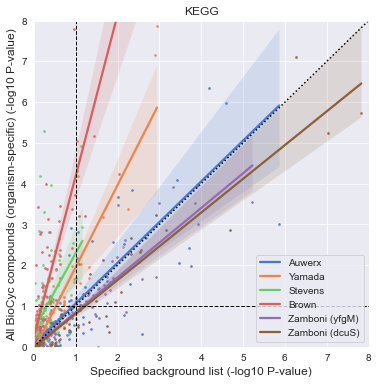

In [4]:
def plot_log_pvalues(db="KEGG"):
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    plt_dict = {}
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        ora_res_pvals = np.negative(np.log10(ora_res["P-value"].tolist()))
        ora_res_all_pvals = np.negative(np.log10(ora_res_all["P-value"].tolist()))
        plt_dict[i] = [ora_res_pvals, ora_res_all_pvals]

    plt.figure(figsize=(6, 6))
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]
        # jittered_y = y + 0.1 * np.random.rand(len(y)) - 0.05
        # jittered_x = x + 0.1 * np.random.rand(len(x)) - 0.05
        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         scatter_kws={'s': 3})
    ax.set_xlabel("Specified background list (-log10 P-value)",
                  fontsize=12)
    ax.set_ylabel("All BioCyc compounds (organism-specific) (-log10 P-value)",
                  fontsize=12)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys())
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG")
#     plt.savefig("../Figures/logp_plot_BioCyc.png", dpi=300)
    plt.show()
plot_log_pvalues(db="KEGG")

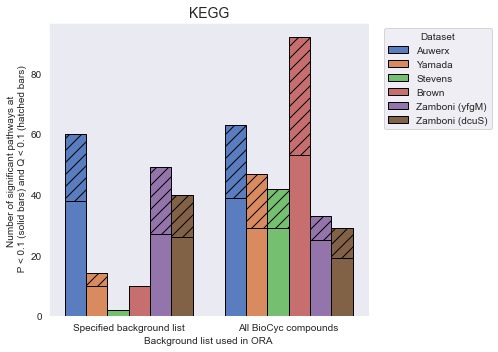

In [6]:
def plot_grouped_stacked_bar(db="KEGG"):
    dataframes = []
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        n_p_less_01 = len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01 = len(ora_res[ora_res["P-adjust"] < 0.1]["P-adjust"].tolist())
        n_p_less_01_all = len(ora_res_all[ora_res_all["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01_all = len(ora_res_all[ora_res_all["P-adjust"] < 0.1]["P-adjust"].tolist())
        df = pd.DataFrame([[n_p_less_01, n_q_less_01], [n_p_less_01_all, n_q_less_01_all]],
                          index=["Specified background list", "All KEGG compounds"], columns=["P", "Q"])
        df["Name"] = "df" + i
        dataframes.append(df)

    dfall = pd.concat([pd.melt(i.reset_index(),
                               id_vars=["Name", "index"])  # transform in tidy format each df
                       for i in dataframes],
                      ignore_index=True)

    dfall.set_index(["Name", "index", "variable"], inplace=True)
    dfall["vcs"] = dfall.groupby(level=["Name", "index"]).cumsum()
    dfall.reset_index(inplace=True)
    sns.set_style("dark")
    sns.set_palette("muted")
    plt.figure(figsize=(7, 5))
    for i, g in enumerate(dfall.groupby("variable")):
        ax = sns.barplot(data=g[1],
                         x="index",
                         y="vcs",
                         hue="Name",
                         zorder=-i,  # so first bars stay on top
                         edgecolor="k")
    ax.set_xlabel('Background list used in ORA')
    ax.set_ylabel('Number of significant pathways at \n P < 0.1 (solid bars) and Q < 0.1 (hatched bars)')
    labels = ["Auwerx", "Yamada", "Stevens", "Brown", "Zamboni (yfgM)", "Zamboni (dcuS)"]
    h, l = ax.get_legend_handles_labels()
    plt.legend(h[0:6], labels, title="Dataset", bbox_to_anchor=(1.4, 1), loc="upper right")
    # Set hatches for q-values bars
    plt.subplots_adjust(right=0.75)
    bars = ax.patches
    for i in range(12, 24, 1):
        bars[i].set_hatch('//')
    plt.title("KEGG", fontsize=14)
    plt.tight_layout()
#     plt.savefig("../Figures/all_vs_experimental_barchart_BioCyc.png", dpi=300)
    plt.show()


plot_grouped_stacked_bar(db="KEGG")

### Background list size reduction

In [ ]:
def reduce_background_set(db="KEGG"):
    '''
    Repeats random background list reduction 10 times. 
    '''
    percentage_reductions_keep_DEM = [i for i in range(100, 45, -5)]
    percentage_reductions = [i for i in range(100, 5, -5)]
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_lists_keep_DEM = []
    results_lists = []
    for d in d_sets.keys():
        for i in percentage_reductions:
            res = utils.reduce_background_list_ora(d_sets[d][1], i, d_sets[d][0], d_sets[d][2], keep_DEM=False)
            results_lists.append([d, i] + res)
        for i in percentage_reductions_keep_DEM:
            res_keep_DEM = utils.reduce_background_list_ora(d_sets[d][1], i, d_sets[d][0], d_sets[d][2], keep_DEM=True)
            results_lists_keep_DEM.append([d, i] + res_keep_DEM)

    res_df = pd.DataFrame(results_lists,
                          columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                   "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                   "q_std", "sd_proportion_p_vals"])
    res_df_keep_DEM = pd.DataFrame(results_lists_keep_DEM,
                                   columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                            "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                            "q_std", "sd_proportion_p_vals"])
#     res_df_keep_DEM.to_csv("Background_reduction_simulation_keep_DEM.csv")
#     res_df.to_csv("Background_reduction_simulation.csv")
    # simulation_res = pd.read_csv("Background_reduction_simulation.csv")
    # simulation_res_keep_DEM = pd.read_csv("Background_reduction_simulation_keep_DEM.csv")
    simulation_res = res_df
    simulation_res_keep_DEM = res_df_keep_DEM
    with plt.style.context('seaborn'):
        fig = plt.figure(figsize=(10, 6))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharey=ax1)
        ax1.set_title("Random background list reduction")
        for i in d_sets.keys():
            ax1.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage reduction'],
                         simulation_res[simulation_res["Dataset"] == i]['mean_proportion_p_vals'],
                         yerr=simulation_res[simulation_res["Dataset"] == i]['sd_proportion_p_vals'],
                         label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax1.set_xlim(100, 10)
        ax2.set_title("No DA metabolite removal")
        for i in d_sets.keys():
            ax2.errorbar(simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['Percentage reduction'],
                         simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['mean_proportion_p_vals'],
                         yerr=simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['sd_proportion_p_vals'],
                         label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax2.set_xlim(100, 50)
        fig.suptitle("Reactome", fontsize=14)
        handles, labels = ax1.get_legend_handles_labels()
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.grid(False)

        plt.ylabel("Proportion of pathways significant at P < 0.1 \n compared to at baseline (original background set)")
        plt.xlabel("Percentage of original background list")
        plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig("background_list_reduction_proportion_Reactome.png", dpi=300)
        plt.show()

reduce_background_set(db="KEGG")

<a id='s2'></a>
## List of input metabolites

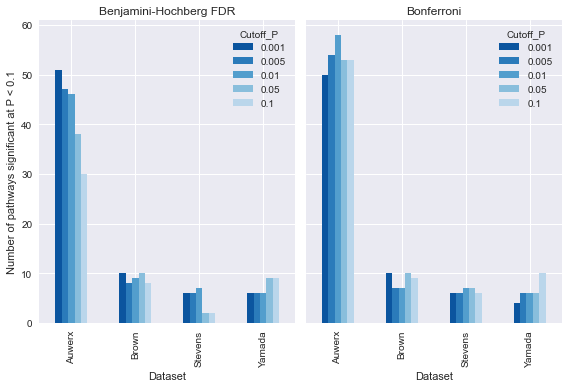

In [8]:
def vary_pval():
    cutoffs = [0.001, 0.005, 0.01, 0.05, 0.1]
    multiple_test_options = ["bonferroni", "fdr_bh"]
    res_list = []
    for d in ["Auwerx", "Brown", "Yamada", "Stevens"]:
        for c in cutoffs:
            for m in multiple_test_options:
                t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                DA_metabolites = t_test_res[t_test_res["P-adjust"] < c]["Metabolite"].tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, c, m, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])

    res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "Multiple_correction_method", "n_p_less_01"])
    res_df_FDR_BH = res_df[res_df["Multiple_correction_method"] == "fdr_bh"]
    res_df_FDR_BH = res_df_FDR_BH.drop("Multiple_correction_method", axis=1)
    res_df_FDR_BH = res_df_FDR_BH.pivot(index="Dataset", columns="Cutoff_P", values="n_p_less_01")
    res_df_bonferroni = res_df[res_df["Multiple_correction_method"] == "bonferroni"]
    res_df_bonferroni = res_df_bonferroni.drop("Multiple_correction_method", axis=1)
    res_df_bonferroni = res_df_bonferroni.pivot(index="Dataset", columns="Cutoff_P",
                                        values="n_p_less_01")

    with plt.style.context('seaborn'):
        sns.set_palette("Blues_r")
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

        res_df_FDR_BH.plot.bar(ax=ax1)
        ax1.set_title('Benjamini-Hochberg FDR')
        ax1.set_ylabel("Number of pathways significant at P < 0.1")

        res_df_bonferroni.plot.bar(ax=ax2)
        ax2.set_title('Bonferroni')
        plt.tight_layout()
#         plt.savefig("../Figures/vary_pvalue_cutoff.png", dpi=300)
        plt.show()

vary_pval()


<a id='s3'></a>
## General vs. organism-specific pathway set

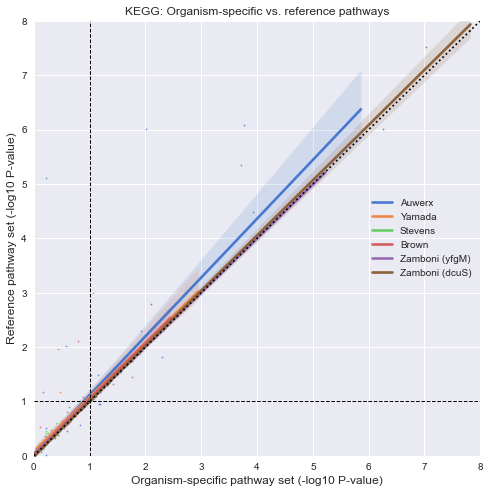

In [20]:
def organism_vs_reference(db="KEGG"):
    d_sets = datasets
    # if db == "Reactome":
    #     d_sets = datasets_reactome
    # if db == "Cyc":
    #     d_sets = datasets_biocyc
    plt_dict = {}
    for i in d_sets.keys():
        ora_res_org = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_ref = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], KEGG_reference_pathways)
        intersect = (set(ora_res_org["Pathway_ID"].str.slice(start=-5).tolist()) & set(ora_res_ref["Pathway_ID"].str.slice(start=-5).tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_ref = ora_res_ref[ora_res_ref["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org = ora_res_org[ora_res_org["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org_pvals = np.negative(np.log10(ora_res_org["P-value"].tolist()))
        ora_res_ref_pvals = np.negative(np.log10(ora_res_ref["P-value"].tolist()))
        plt_dict[i] = [ora_res_org_pvals, ora_res_ref_pvals]

    plt.figure(figsize=(8, 8))
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]

        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         scatter_kws={'s': 3})
    ax.set_xlabel("Organism-specific pathway set (-log10 P-value)",
                  fontsize=12)
    ax.set_ylabel("Reference pathway set (-log10 P-value)",
                  fontsize=12)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys())
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG: Organism-specific vs. reference pathways")
#     plt.savefig("../Figures/organism_vs_reference_pathways_pvals.png", dpi=300)
    plt.show()

organism_vs_reference()

#### Calculate average pathway size

In [14]:
def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [15]:
ref_paths = process_paths(KEGG_reference_pathways)
human_paths = process_paths(KEGG_human_pathways)
avg_ref_pathway_size = np.mean([len(v) for k, v in ref_paths.items()])
avg_hum_pathway_size = np.mean([len(v) for k, v in human_paths.items()])
# mouse_pathway_size = 
# eco_pathway_size = 
print("Average reference pathway size:", avg_ref_pathway_size)
print("Average human pathway size:", avg_hum_pathway_size)
print("Total reference pathways:", len(ref_paths))
print("Total human pathways:", len(human_paths))

Average reference pathway size: 44.88859416445624
Average human pathway size: 29.582375478927204
Total reference pathways: 377
Total human pathways: 261


#### Calculate Jaccard index for common pathways

In [13]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [31]:
common_paths_ref_human = list(set([i[3:] for i in ref_paths.keys()]) & set([i[3:] for i in human_paths.keys()]))

jaccard_indexes_human_ref = []
for pathway_id in common_paths_ref_human:
    jaccard_index = jaccard_similarity(ref_paths["map"+str(pathway_id)], human_paths["hsa"+str(pathway_id)])
    jaccard_indexes_human_ref.append(jaccard_index)
    
print("Average Jaccard index for common reference and human pathways:", np.mean(jaccard_indexes_human_ref))

Average Jaccard index for common reference and human pathways: 0.7489924529127291


<a id='s4'></a>
## Database updates

In [16]:
KEGG_hum_2020 = process_paths(KEGG_human_pathways)
KEGG_hum_2017 = process_paths(pd.read_csv("Old_KEGG/PathwayMetabolite5070_human_08_2017.csv", dtype=str, index_col=0, engine='python'))
KEGG_hum_2015 = process_paths(pd.read_csv("Old_KEGG/PathwayMetabolite2903_human_04_2015.csv", dtype=str, index_col=0, engine='python'))
years = {"KEGG_2020": KEGG_hum_2020, "KEGG_2017": KEGG_hum_2017, "KEGG_2015": KEGG_hum_2015}
print(len(KEGG_hum_2015))

87


In [17]:
pathway_stats = pd.DataFrame(index=["KEGG_2020", "KEGG_2017", "KEGG_2015"], columns=["Number of pathways", "Number of unique compounds", "Mean pathway length"])
for db in pathway_stats.index:
    pathway_stats.loc[db, "Number of pathways"] = len(years[db])
    pathway_stats.loc[db, "Number of unique compounds"] = len(set([item for sublist in years[db].values() for item in sublist]))
    pathway_stats.loc[db, "Mean pathway length"] = np.mean([len(i) for i in years[db].values()])

In [18]:
pathway_stats

,Number of pathways,Number of unique compounds,Mean pathway length
KEGG_2020,261,3372,29.582375
KEGG_2017,87,1572,36.666667
KEGG_2015,87,1560,37.298851


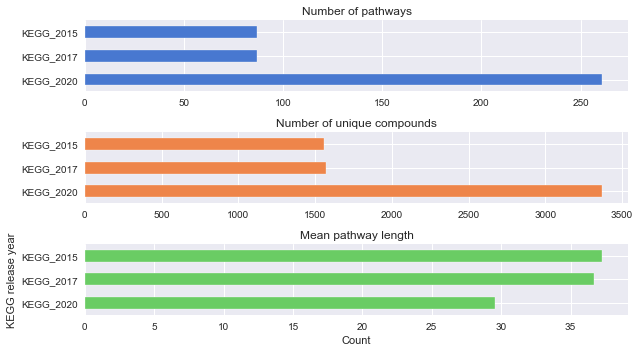

In [19]:
sns.set_style("darkgrid")
sns.set_palette("muted")
pathway_stats.plot.barh(figsize=(9, 5), subplots=True, sharex=False, sharey=True, legend=False)
plt.xlabel("Count")
plt.ylabel("KEGG release year")
plt.tight_layout()
# plt.savefig("../Figures/KEGG_years_comparison.png", dpi=300)

<a id='s5'></a>
## Metabolite misidentification

#### Random misidentification

In [ ]:
# Random misidentification
percentage_misidentifications = [i for i in range(0, 100, 10)]
def random_misidentification(db="KEGG"):
    results_lists = []
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    for d in d_sets.keys():
        print(d)
        if d.startswith("Zamboni"):
            for i in [i for i in range(0, 70, 10)]:
                print(i)
                res = utils.misidentify_metabolites(i, d_sets[d][4], d_sets[d][3], d_sets[d][1], d_sets[d][2],
                                                    zamboni=True)
                results_lists.append([d, i] + res[:-1])
        else:
            for i in percentage_misidentifications:
                print(i)
                res = utils.misidentify_metabolites(i, d_sets[d][4], d_sets[d][3], d_sets[d][1], d_sets[d][2])
                results_lists.append([d, i] + res[:-1])

    res_df = pd.DataFrame(results_lists, columns=["Dataset", "Percentage misidentification", "n_p_less_0.1", "n_q_less_0.1", "p_std", "q_std"])
    # res_df.to_csv("Metabolite_misidentification_simulation_random_Reactome.csv")

    simulation_res = res_df
    plt.figure()
    plt.style.use("seaborn")
    for i in d_sets.keys():
        plt.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage misidentification'],
                     simulation_res[simulation_res["Dataset"] == i]['n_p_less_0.1'],
                     yerr=simulation_res[simulation_res["Dataset"] == i]['p_std'],
                     label=i, fmt='o', linestyle="solid", capsize=5,  markeredgewidth=2, markersize=4)
    plt.title("Reactome", fontsize=14)
    plt.legend()
    plt.ylabel("Mean number of pathways significant at P < 0.1 \n based on 100 random permutations")
    plt.xlabel("Percentage of metabolites misidentified")
    plt.savefig("metabolite_random_misidentification_Reactome2.png", dpi=300)
    plt.show()

random_misidentification(db="KEGG")

#### Misidentification by mass

In [ ]:
def misidentification_mass_plot(db="KEGG"):
    d_sets = datasets
    masses = KEGG_compounds_masses
    if db == "Reactome":
        d_sets = datasets_reactome
        masses = Reactome_compounds_masses
    results_lists = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Zamboni"):
            for i in d_sets[d][5]:
                print(i)
                res = utils.misidentify_metabolites_by_mass(i, d_sets[d][4], d_sets[d][2], masses,
                                                d_sets[d][3], zamboni=True)
                results_lists.append([d, i] + res)
        else:
            for i in d_sets[d][5]:
                print(i)
                res = utils.misidentify_metabolites_by_mass(i, d_sets[d][4], d_sets[d][2], masses,
                                                            d_sets[d][3], zamboni=False)
                results_lists.append([d, i] + res)

    res_df = pd.DataFrame(results_lists, columns=["Dataset", "Percentage misidentification", "n_p_less_0.1", "n_q_less_0.1", "p_std", "q_std", "sig_paths"])
    # res_df.to_csv("Metabolite_misidentification_by_mass_simulation_Reactome.csv")

    simulation_res = res_df
    print(simulation_res.head)
    plt.figure()
    plt.style.use("seaborn")
    for i in d_sets.keys():
        plt.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage misidentification'],
                     simulation_res[simulation_res["Dataset"] == i]['n_p_less_0.1'],
                     yerr=simulation_res[simulation_res["Dataset"] == i]['p_std'],
                     label=i, fmt='o', linestyle="solid", capsize=5,  markeredgewidth=2, markersize=4)
    # plt.title("Number of pathways with P-values < 0.1 in response to \n varying levels of metabolite misidentification", fontsize=14)
    plt.legend()
    plt.ylabel("Mean number of pathways significant at P < 0.1")
    plt.xlabel("Percentage of metabolites misidentified by mass")
    plt.title("KEGG", fontsize=14)
    # plt.savefig("metabolite_misidentification_by_mass_Reactome.png", dpi=300)
    plt.show()

misidentification_mass_plot(db="KEGG")

#### Misidentification by chemical formula

In [ ]:
def misidentification_formula_plot(db="KEGG"):
    d_sets = datasets
    compounds = KEGG_compounds_masses
    if db == "Reactome":
        d_sets = datasets_reactome
        compounds = Reactome_compounds_masses
    results_lists = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Zamboni"):
            for i in d_sets[d][6]:
                print(i)
                res = utils.misidentify_metabolites_by_formula(i, d_sets[d][4], d_sets[d][2], compounds,
                                                d_sets[d][3], zamboni=True)
                results_lists.append([d, i] + res)
        else:
            for i in d_sets[d][6]:
                print(i)
                res = utils.misidentify_metabolites_by_formula(i, d_sets[d][4], d_sets[d][2], compounds,
                                                            d_sets[d][3], zamboni=False)
                results_lists.append([d, i] + res)

    res_df = pd.DataFrame(results_lists, columns=["Dataset", "Percentage misidentification", "n_p_less_0.1", "n_q_less_0.1", "p_std", "q_std", "sig_paths"])
    res_df.to_csv("Metabolite_misidentification_by_formula_simulation_Reactome.csv")

    simulation_res = res_df
    print(simulation_res.head)
    plt.figure()
    plt.style.use("seaborn")
    for i in d_sets.keys():
        plt.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage misidentification'],
                     simulation_res[simulation_res["Dataset"] == i]['n_p_less_0.1'],
                     yerr=simulation_res[simulation_res["Dataset"] == i]['p_std'],
                     label=i, fmt='o', linestyle="solid", capsize=5,  markeredgewidth=2, markersize=4)
    plt.title("Reactome", fontsize=14)
    plt.legend()
    plt.ylabel("Mean number of pathways significant at P < 0.1")
    plt.xlabel("Percentage of metabolites misidentified by formula")
    plt.savefig("metabolite_misidentification_by_formula_Reactome.png", dpi=300)
    plt.show()

misidentification_formula_plot(db="KEGG")

### Pathway re-discovery and pathway mis-discovery rate

In [ ]:
# Parameter grid for TPR/FPR heatmaps. Numbers correspond to indexes in datasets param grids.
param_grid_heatmaps = {"random": [utils.misidentify_metabolites, 4, 3, 1, 2, [i for i in range(0, 70, 10)]],
                       "mass": [utils.misidentify_metabolites_by_mass, 4, 2, 7, 3, [i for i in range(1, 7, 1)]],
                       "formula": [utils.misidentify_metabolites_by_formula, 4, 2, 7, 3, [i for i in range(1, 6, 1)]]}

def TPR_heatmap(pg, fname, db="KEGG"):
    """
    Plots TRP/FPR heatmap
    :param misidenetification_funct: function for misidentification
    :param db: Database, default is KEGG
    :return: heatmap
    """
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_TPR = []
    results_FPR = []
    for d in ["Auwerx", "Brown", "Yamada", "Zamboni (dcuS)", "Zamboni (yfgM)"]:
        print(d)
        if d.startswith("Zamboni"):
            original_pathways = pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]],
                                                    zamboni=True)[4][0]

            for i in pg[5]:
                print(i)
                res = pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]],
                                                    zamboni=True)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways) # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = number_common_paths/total_significant_paths
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len([i for i in x if i not in original_pathways])/total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR])
                results_FPR.append([d, i, avg_fraction_FPR])

        else:
            original_pathways = pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], zamboni=False)[4][0]
            for i in pg[5]:
                print(i)
                res = pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], zamboni=False)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways) # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = number_common_paths/total_significant_paths
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len([i for i in x if i not in original_pathways])/total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR])
                results_FPR.append([d, i, avg_fraction_FPR])
    res_df_TPR = pd.DataFrame(results_TPR,
                          columns=["Dataset", "Percentage misidentification", "Average fraction"])
    res_df_FPR = pd.DataFrame(results_FPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction"])

    res_df_TPR = res_df_TPR.pivot(index='Percentage misidentification', columns='Dataset', values='Average fraction')
    res_df_FPR = res_df_FPR.pivot(index='Percentage misidentification', columns='Dataset', values='Average fraction')
    # res_df = pd.read_csv("metabolite_misidentification_heatmap.csv", index_col=0)
    plt.style.use("seaborn")
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('TPR')
    sns.heatmap(res_df_TPR, annot=True, cmap="mako", square=True)
    plt.subplot(122)
    plt.title('FPR')
    sns.heatmap(res_df_FPR, annot=True, cmap="rocket_r", square=True)
    plt.subplots_adjust(bottom=0.28)
        # plt.ylabel("Percentage metabolite misidentification (%)")
    plt.savefig(fname, dpi=300)
    plt.show()

# TPR_heatmap(param_grid_heatmaps["random"], "random_misidentification_heatmap_KEGG_new.png", db="KEGG")
# TPR_heatmap(param_grid_heatmaps["formula"], "formula_misidentification_heatmap_KEGG_new.png", db="KEGG")
# TPR_heatmap(param_grid_heatmaps["mass"], "mass_misidentification_heatmap_KEGG_new.png", db="KEGG")

<a id='s6'></a>
## Metabolite polarity

In [11]:
from matplotlib_venn import venn2

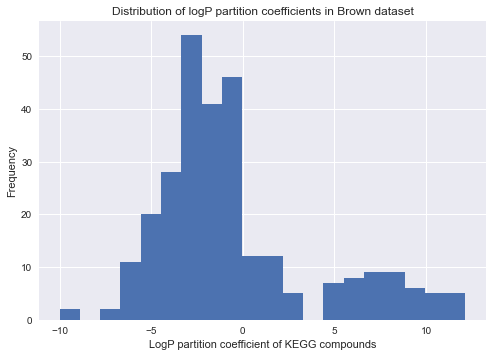

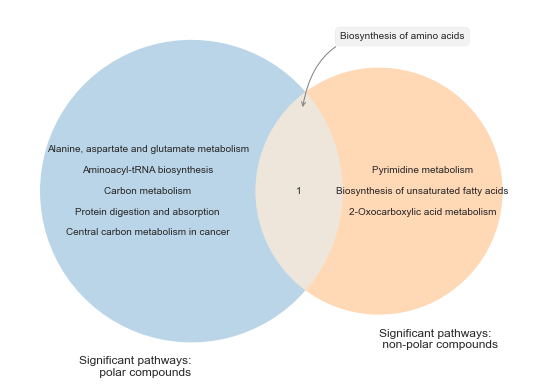

In [12]:
logp_all = pd.read_csv("hmdb_logp_all.csv", index_col=0)

# DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
# DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
# DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
# DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
# DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
# KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
# KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)

cols = mat_brown.columns.tolist()
matching_id = logp_all[logp_all["kegg_id"].isin(cols)]
plt.style.use("seaborn")
plt.hist(matching_id["logp"], bins=20)
plt.xlabel("LogP partition coefficient of KEGG compounds")
plt.ylabel("Frequency")
plt.title("Distribution of logP partition coefficients in Brown dataset")
plt.show()

# Brown - split at -1 or -2
def log_p_venn(cutoff, mat, pathways):
    polar = matching_id[matching_id["logp"] < cutoff]
    nonpolar = matching_id[matching_id["logp"] > cutoff]

    polar_mat = mat.filter(polar["kegg_id"])
    polar_mat = polar_mat.iloc[:, ~polar_mat.columns.duplicated()]
    ttest_polar = utils.t_tests(polar_mat, mat["Group"], "fdr_bh")
    dem_polar = ttest_polar[ttest_polar["P-adjust"] <= 0.05]["Metabolite"].tolist()
    ora_polar = utils.over_representation_analysis(dem_polar, polar_mat.columns.tolist(), pathways)

    nonpolar_mat = mat.filter(nonpolar["kegg_id"])
    nonpolar_mat = nonpolar_mat.iloc[:, ~nonpolar_mat.columns.duplicated()]
    ttest_nonpolar = utils.t_tests(nonpolar_mat, mat["Group"], "fdr_bh")
    dem_nonpolar = ttest_nonpolar[ttest_nonpolar["P-adjust"] <= 0.05]["Metabolite"].tolist()
    ora_nonpolar = utils.over_representation_analysis(dem_nonpolar, nonpolar_mat.columns.tolist(), pathways)

    polar_pathways = ora_polar[ora_polar["P-value"] <= 0.1]["Pathway_ID"].tolist()
    nonpolar_pathways = ora_nonpolar[ora_nonpolar["P-value"] <= 0.1]["Pathway_ID"].tolist()
    common_paths = list(set(polar_pathways) & set(nonpolar_pathways))

    pp_names = [' '.join(i.split(' ')[:-4]) for i in ora_polar[ora_polar["P-value"] <= 0.1]["Pathway_name"].tolist()]
    np_names = [' '.join(i.split(' ')[:-4]) for i in ora_nonpolar[ora_nonpolar["P-value"] <= 0.1]["Pathway_name"].tolist()]
    common_names = list(set(pp_names) & set(np_names))

    plt.style.use("seaborn")
    venn = venn2(subsets = (set(polar_pathways),
                            set(nonpolar_pathways)), set_labels = ('Significant pathways:\n polar compounds', 'Significant pathways:\n non-polar compounds'),
                 set_colors=('tab:blue', 'tab:orange'), alpha = 0.3)
    venn.get_label_by_id('100').set_text("\n\n".join([i for i in pp_names if i not in common_names]))
    venn.get_label_by_id('010').set_text("\n\n".join([i for i in np_names if i not in common_names]))
    plt.annotate("\n".join(common_names), xy=venn.get_label_by_id('110').get_position() - np.array([-0.01, -0.25]), xytext=(100,70),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray', linewidth=1))

    plt.tight_layout()
    # plt.savefig("../Figures/logp_brown_venn.png", dpi=300)
    plt.show()

log_p_venn(-2, mat_brown, KEGG_mouse_pathways)